# Spectral Power to Lux
This code converts an ILT Spectrilight spectral power .txt export into an integrated lux value. The INS125 power calibration must be applied, with counts collected through the top of the integrating sphere.

In [1]:
# import modules
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from matplotlib import rcParams
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import colormath as cm
import math
import numpy as np
import pandas as pd
import os

%matplotlib inline

# specify sample file path and location of luminous efficacy table for conversion
light_file = r'C:\Users\tl457\OneDrive - University Of Cambridge 1\1_Data\211104-WhiteLED-Spectrilight\211104-WhiteLED-INS125-Power.txt'
luminous_efficacy_file = r'C:\Users\tl457\OneDrive - University Of Cambridge 1\1_Data\Luminous_Efficacy_Tables.csv' # from http://hyperphysics.phy-astr.gsu.edu/hbase/vision/efficacy.html

# specify matplotlib configuration file path
rc_fname = r'C:\Users\tl457\Documents\GitHub\spectroscopy\plotting_params.txt'

In [2]:
# load sample data
meta_data=pd.read_csv(light_file,sep='\t',nrows=10,index_col=0,names=["value"])
light_spectrum=pd.read_csv(light_file,sep='\t',skiprows=10,index_col=0,names=["power"])
lum_eff=pd.read_csv(luminous_efficacy_file,skiprows=1,index_col=0,names=["photopic","photopic_f","scotopic","scotopic_f"])
meta_data.style

,value
Scan Averages,10
Integration Time,8.000000
X Unit,Wavelength [nm]
X Max,1075.000000
X Min,250.000000
Y Unit,Power [uW/nm]
Y Max,460.000000
Y Min,0.000000
Cal Flag,1
SN,1007131U1


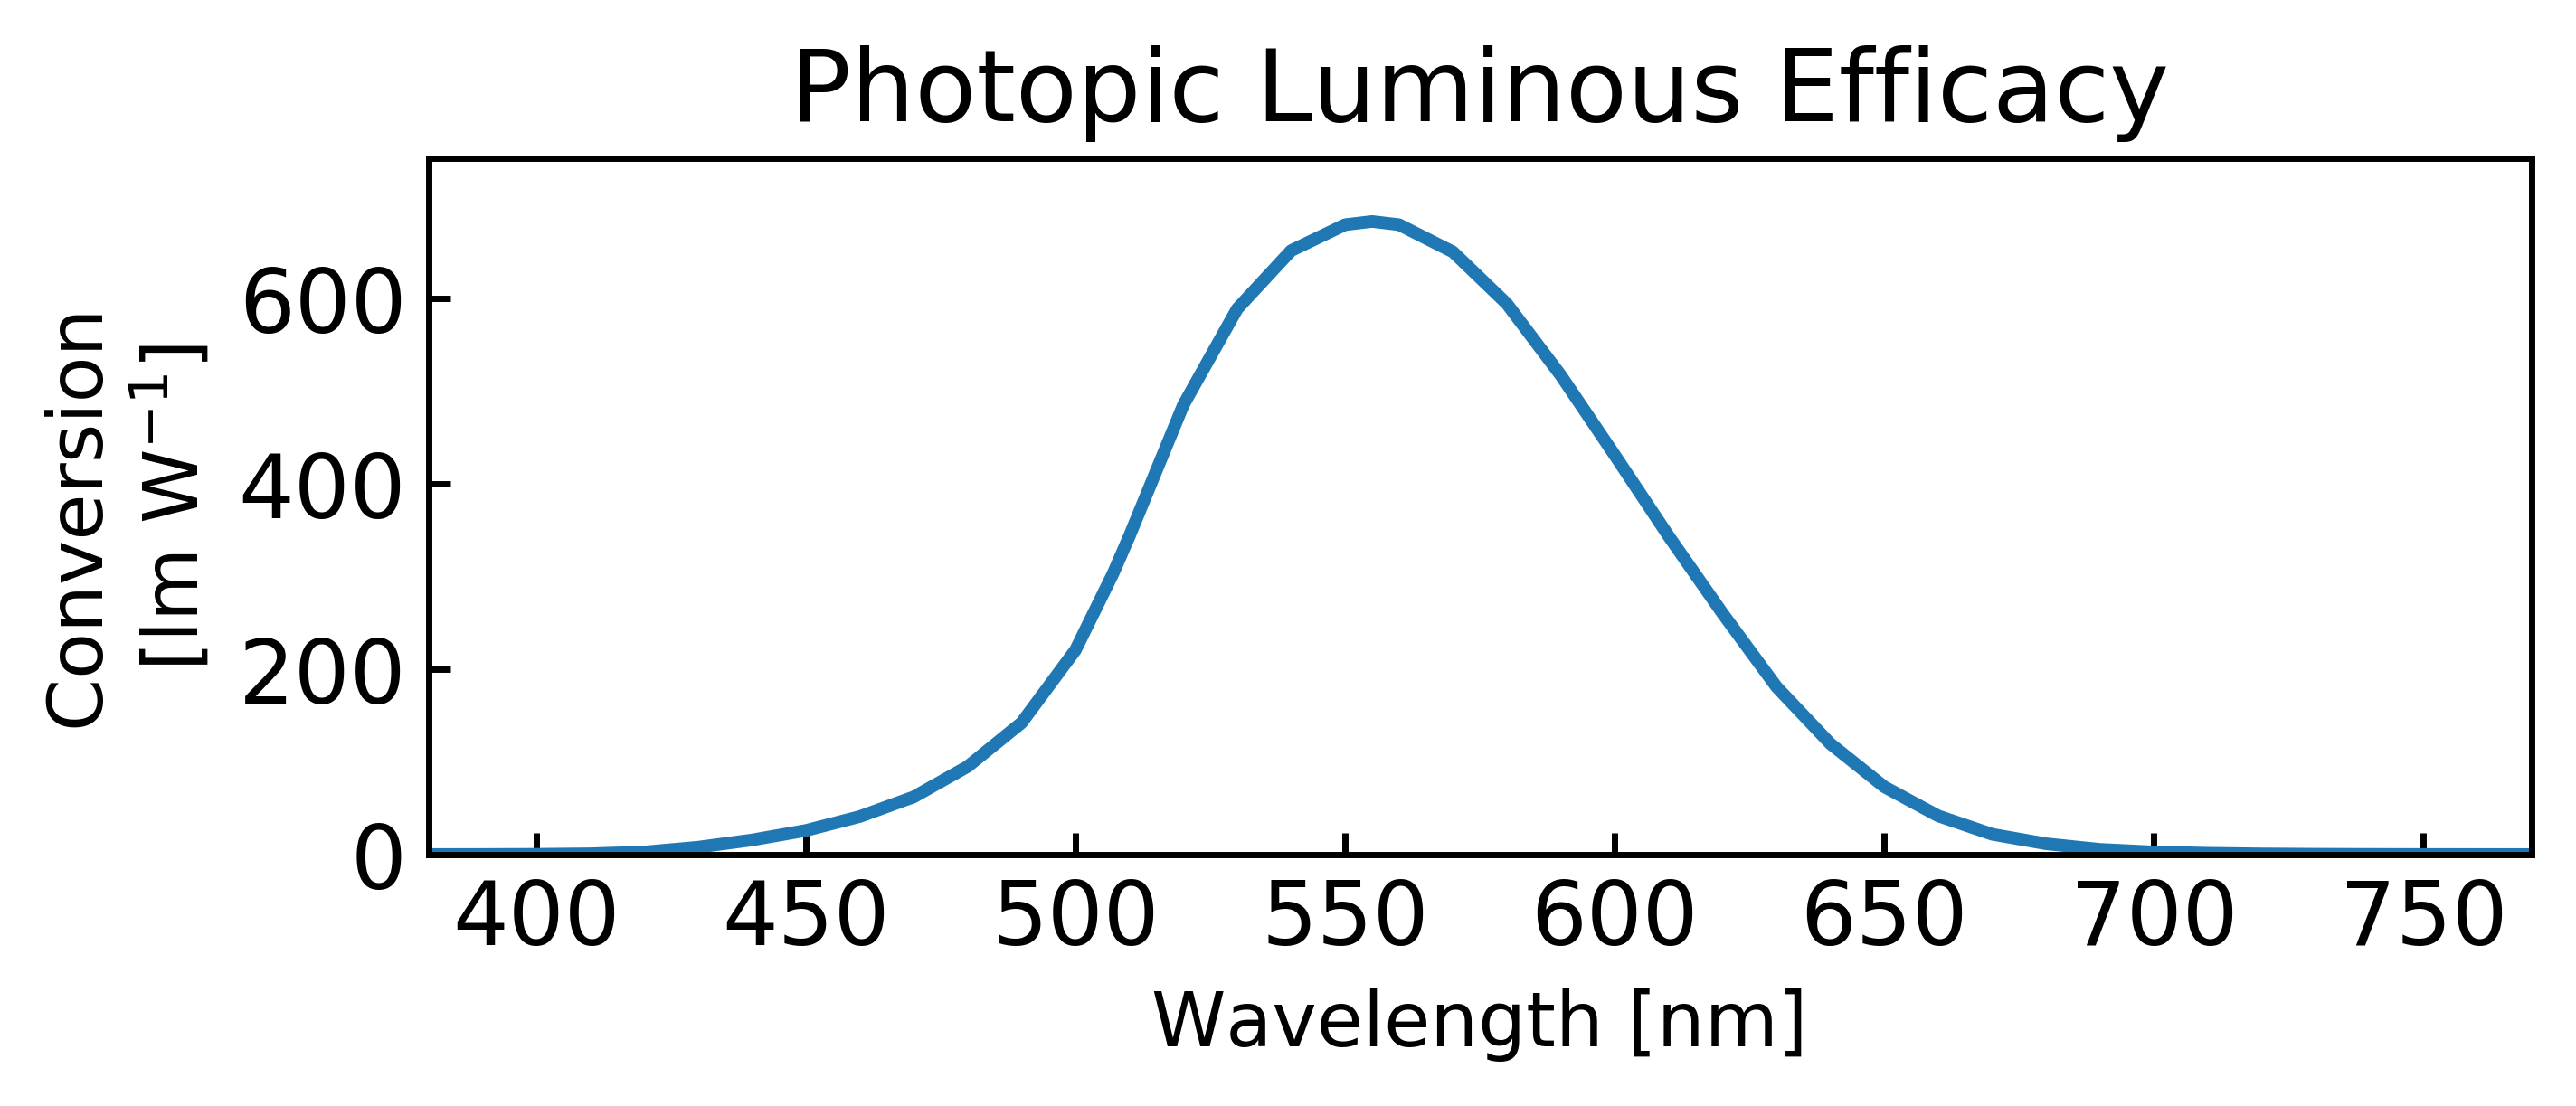

In [3]:
# plot luminous efficacy
with rc_context(fname=rc_fname):
    plt.figure(figsize=(6,2))
    plt.plot(lum_eff["photopic_f"])
    plt.xlim(380,770)
    plt.ylim(0,max(lum_eff["photopic_f"])*1.1)
    plt.xlabel("Wavelength [nm]",fontsize=12)
    plt.ylabel("Conversion \n[lm W$^{-1}$]",fontsize=12)
    plt.title("Photopic Luminous Efficacy")

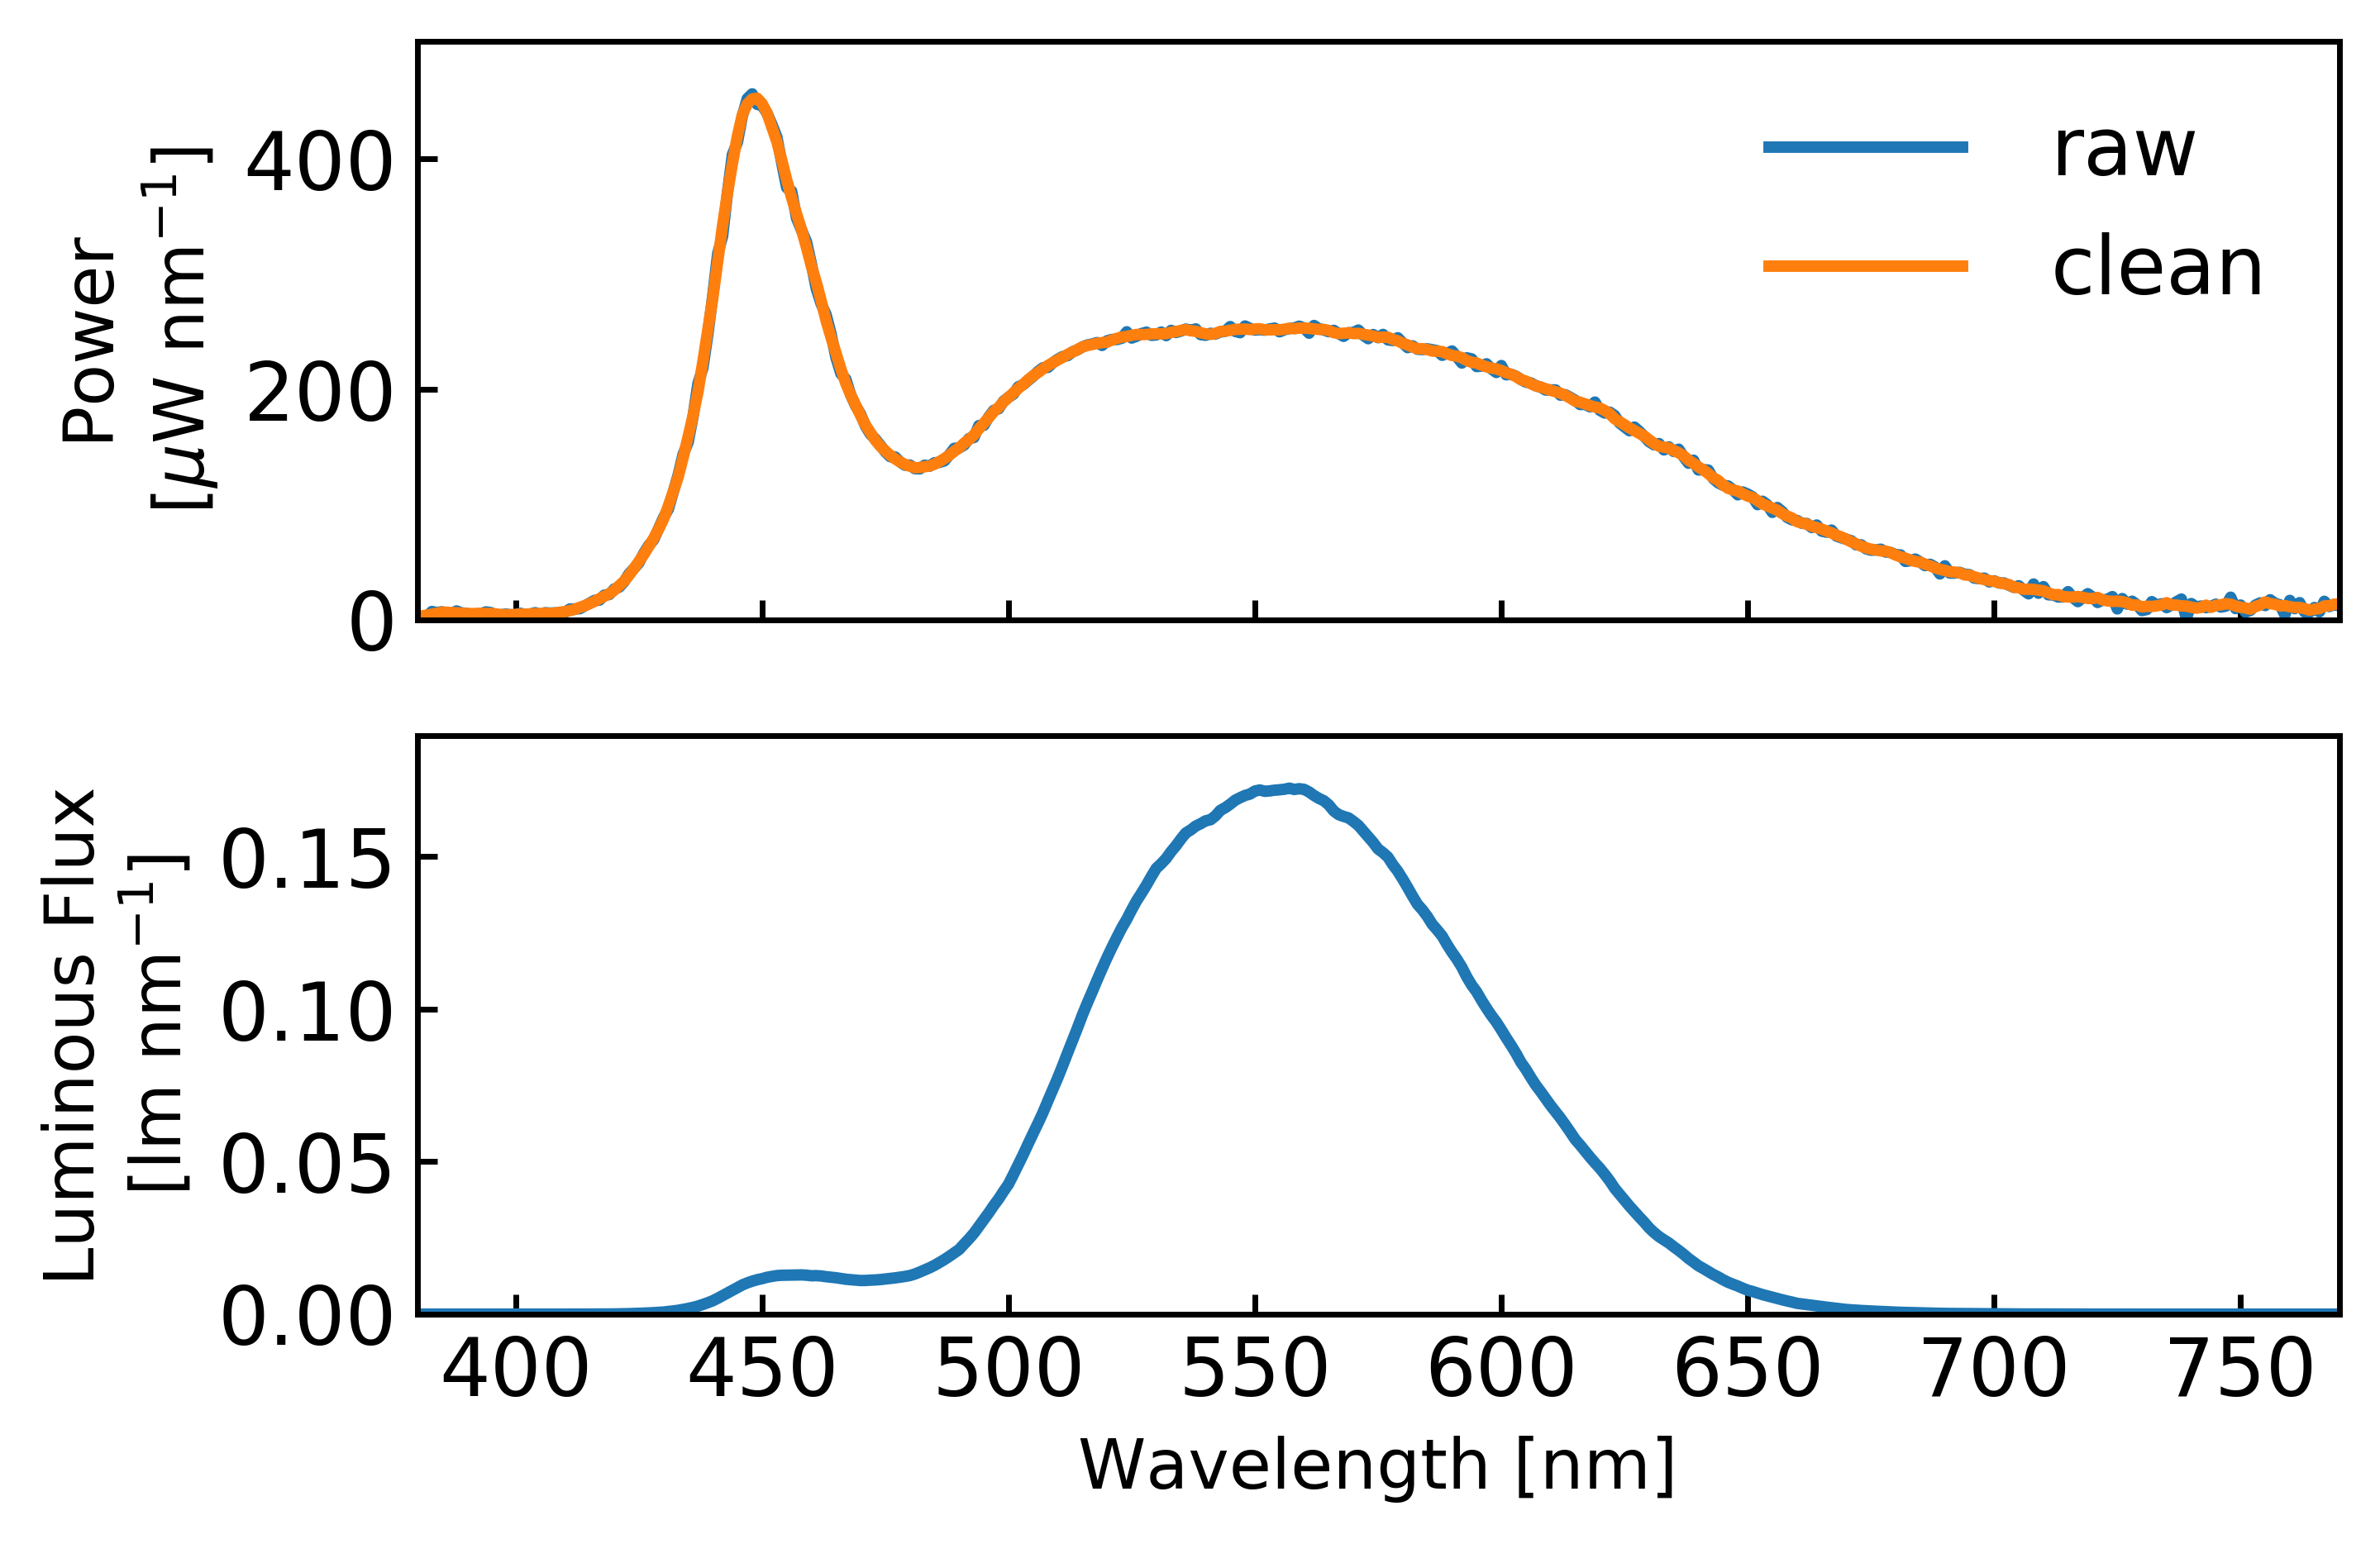

In [4]:
# clean up spectral signal using SG filtering and append to dataframe as new column
sgf_window=9
sgf_order=2
light_spectrum["power_clean"]=savgol_filter(light_spectrum["power"],sgf_window,sgf_order) # uW/nm

# create interpolation function for luminous efficacy
f = interp1d(lum_eff.index, lum_eff["photopic_f"],bounds_error=False,fill_value=0)

# create conversion factor array and append lumen to dataframe as new column
conf_f=f(light_spectrum.index)
light_spectrum["lumen"]=np.multiply(light_spectrum["power_clean"],conf_f*1e-6) # convert from uW to Lm

# plot power and luminous flux
with rc_context(fname=rc_fname):
    fig,axs=plt.subplots(2,figsize=(6,4),sharex=True)
    axs[0].plot(light_spectrum["power"],label='raw')
    axs[0].plot(light_spectrum["power_clean"],label='clean')
    axs[0].legend()
    axs[0].set_ylim(0,max(light_spectrum["power"])*1.1)
    axs[0].set_ylabel("Power \n[$\mu$W nm$^{-1}$]",fontsize=12)
    axs[1].plot(light_spectrum["lumen"])
    axs[1].set_xlim(380,770)
    axs[1].set_ylim(0,max(light_spectrum["lumen"])*1.1)
    axs[1].set_xlabel("Wavelength [nm]",fontsize=12)
    axs[1].set_ylabel("Luminous Flux \n[lm nm$^{-1}$]",fontsize=12)

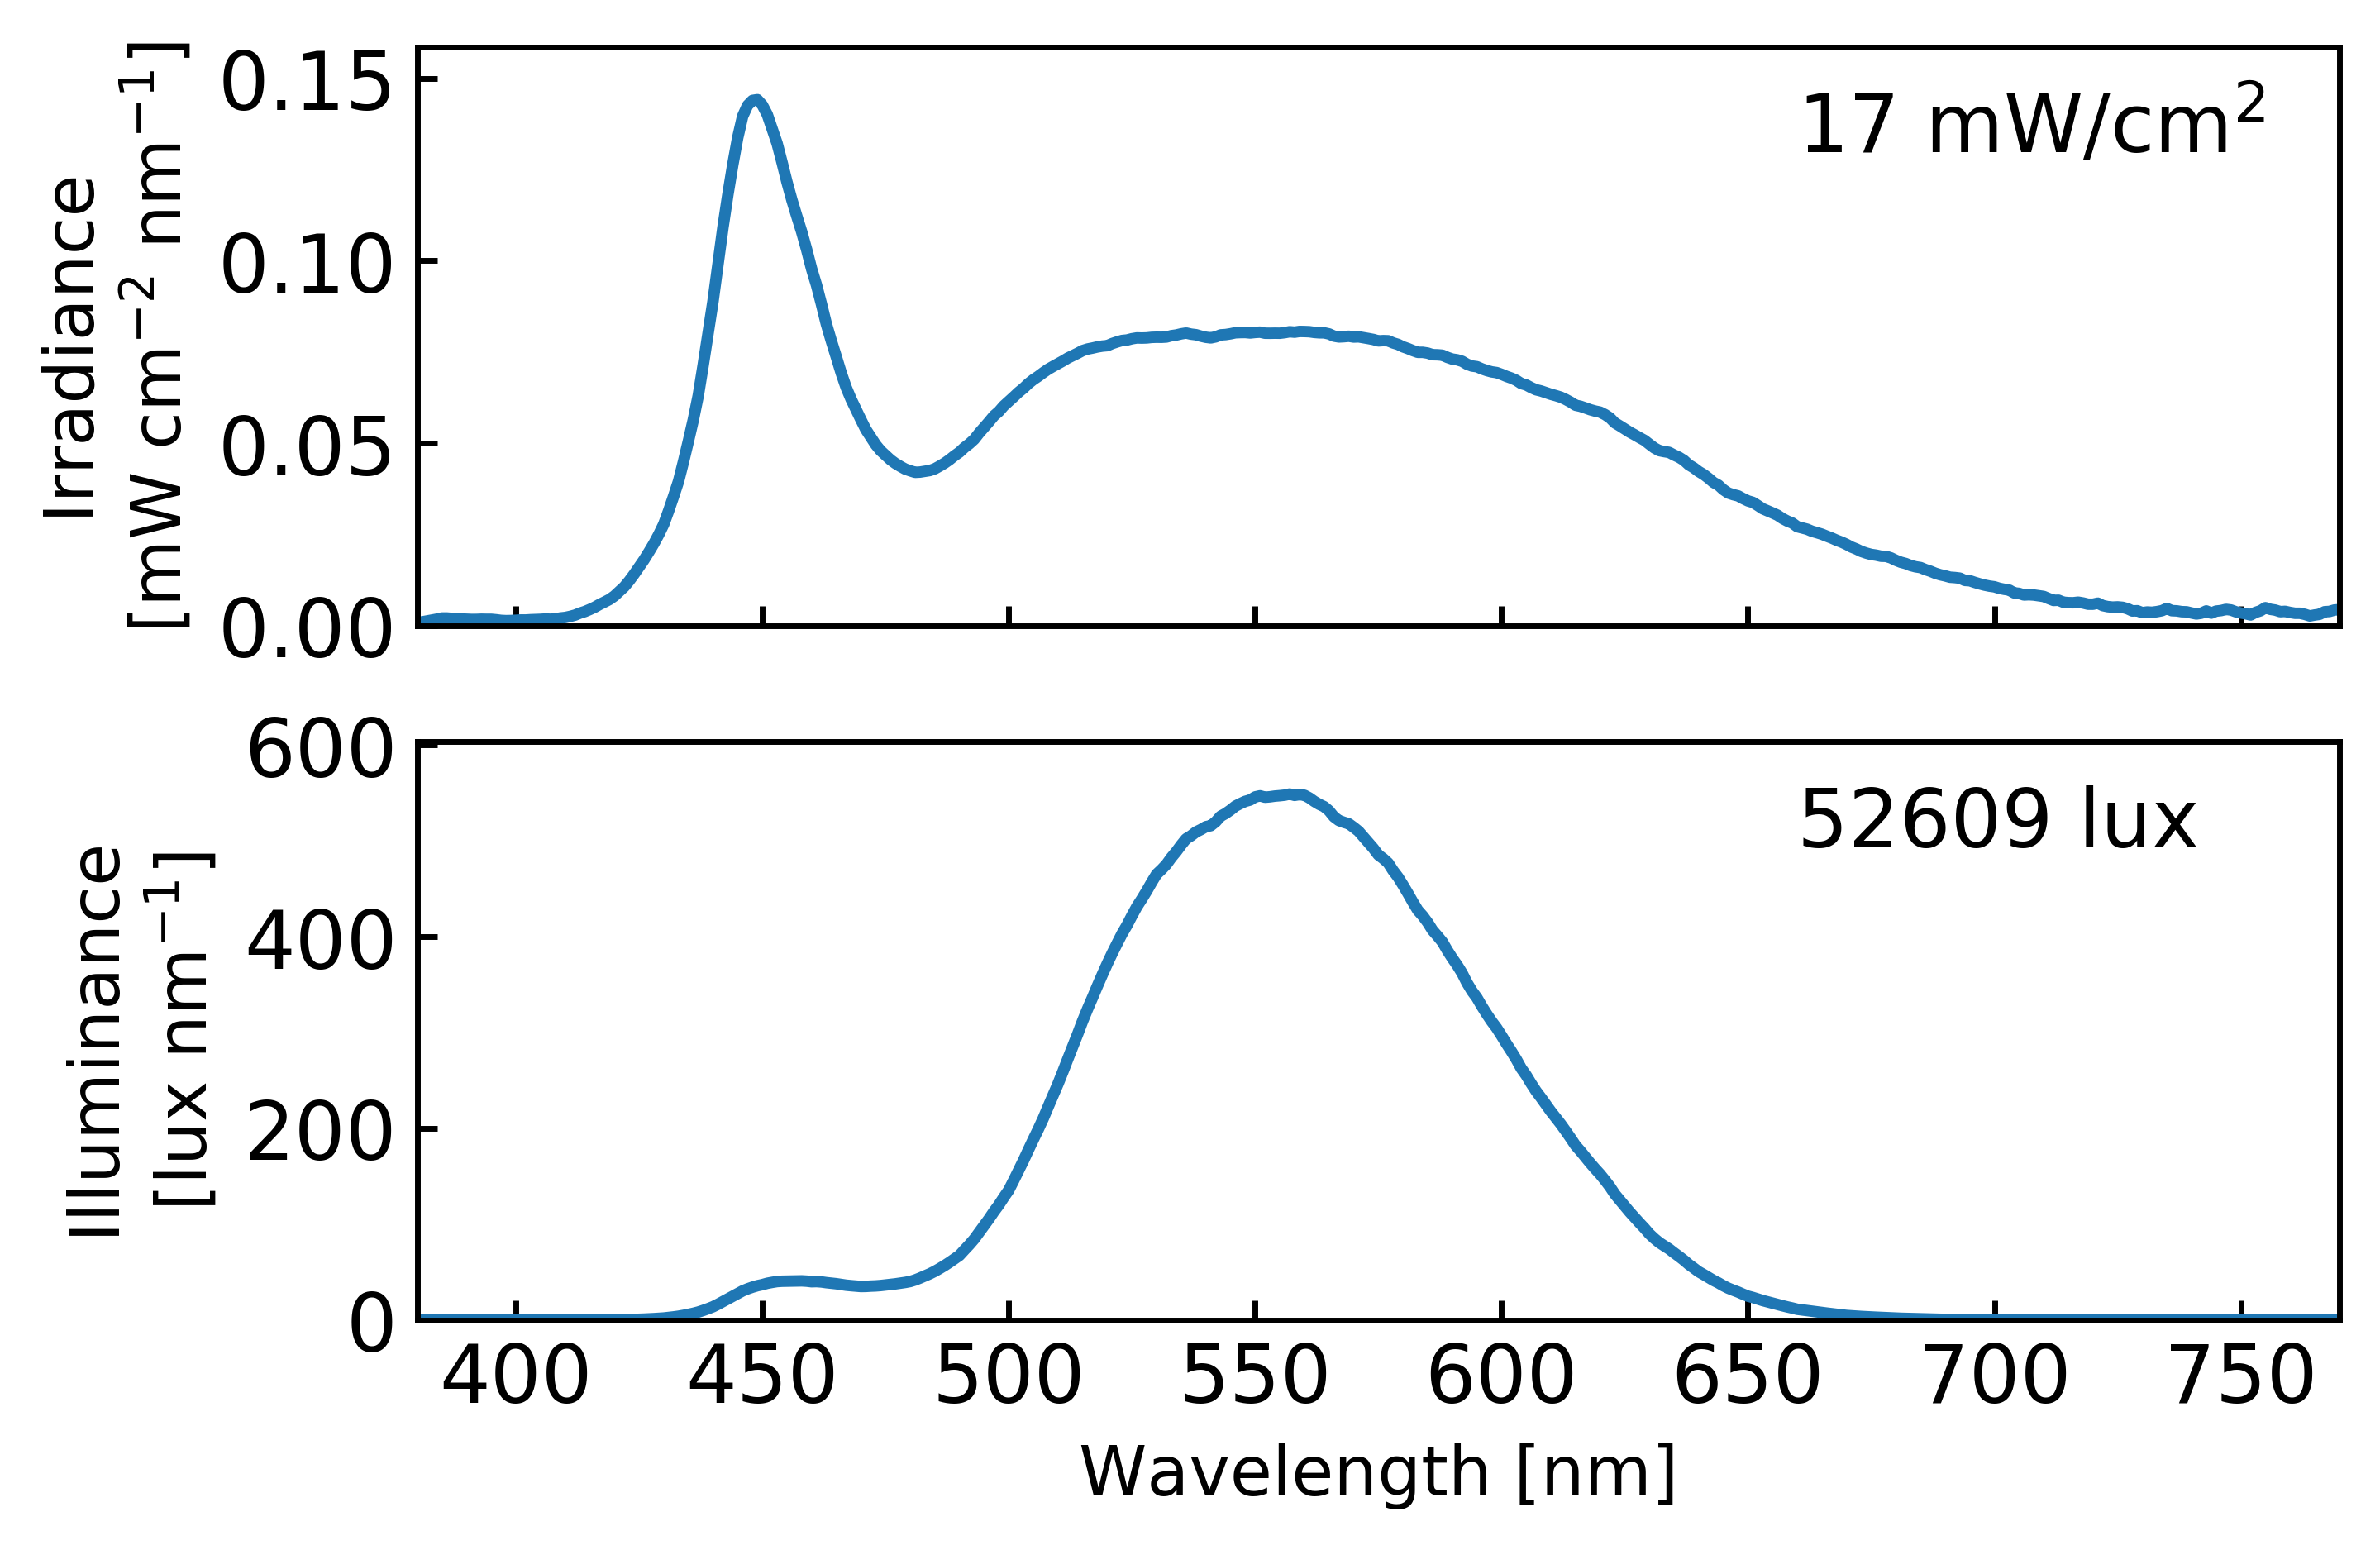

In [5]:
# specify collection area and calculate irradiance (mW/cm^2) and lux (lm/m^2)
area=math.pi*(1e-2)**2 # m^2
light_spectrum["irr"]=np.divide(light_spectrum["power_clean"]*1e-3,area*1e4) #mW/cm^2
light_spectrum["lux"]=np.divide(light_spectrum["lumen"],area)

# integrate illuminance and irradiance for the [380,770]nm part of the spectrum
int_lux=np.trapz(light_spectrum['lux'].values,x=light_spectrum.index)
df_int=light_spectrum.truncate(before=380, after=770)
int_irr=np.trapz(df_int['irr'].values,x=df_int.index)

# plot irradiance and illuminance
with rc_context(fname=rc_fname):
    fig,axs=plt.subplots(2,figsize=(6,4),sharex=True)
    axs[0].plot(light_spectrum["irr"])
    axs[0].text(660,max(light_spectrum["irr"])*0.9,str(int(int_irr))+' mW/cm$^2$')
    axs[0].set_ylim(0,max(light_spectrum["irr"])*1.1)
    axs[0].set_ylabel("Irradiance \n[mW cm$^{-2}$ nm$^{-1}$]",fontsize=12)
    axs[1].plot(light_spectrum["lux"])
    axs[1].text(660,max(light_spectrum["lux"])*0.9,str(int(int_lux))+' lux')
    axs[1].set_xlim(380,770)
    axs[1].set_ylim(0,max(light_spectrum["lux"])*1.1)
    axs[1].set_xlabel("Wavelength [nm]",fontsize=12)
    axs[1].set_ylabel("Illuminance \n[lux nm$^{-1}$]",fontsize=12)